# 9.`xarray`繪圖 (2)：繪製2D資料

## 全球或跨越180經度線的區域地圖

雖然在前面已經介紹過`cartopy`的用法，但由於`cartopy`繪製全球地圖時，中線預設為0度，原則上繪圖的範圍必須限縮在-180至180度 (詳細可以參考[StackOverflow的說明](https://stackoverflow.com/questions/13856123/setting-up-a-map-which-crosses-the-dateline-in-cartopy#_=_))。因此在不額外設定其他參數的話，繪製出的全球地圖如以下範例所示：

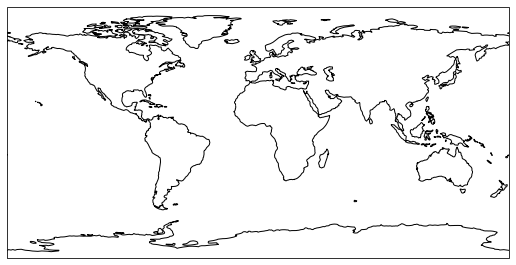

In [1]:
from matplotlib import pyplot as plt
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

plt.figure(figsize=[9,6])                            
proj = ccrs.PlateCarree()    
ax = plt.axes(projection=proj)  
ax.set_global()  
ax.coastlines()

如果繪製地圖的範圍要橫跨180度，需要在投影設定中加上`central_longitude=180`。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)

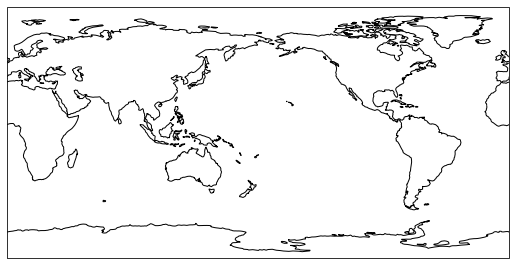

In [2]:
plt.figure(figsize=[9,6])                            
proj = ccrs.PlateCarree(central_longitude=180)    
ax = plt.axes(projection=proj)  
ax.set_global()  
ax.coastlines()

區域地圖繪製還需要額外步驟。假設現在要繪製的地圖經緯度範圍為(20˚S-30˚N, 40˚E-150˚W)，在 **繪圖空間** `ax`上，要指定投影方式`projection=ccrs.PlateCarree(central_longitude=180)`。
`ax.set_extent`中`crs`引數為坐標系統，不需要再給定`central_longitude=180`，否則坐標投影會轉換兩次。同理，資料的`transform`引數也要設定為`projection=ccrs.PlateCarree()`，不需要再指定`central_longitude=180`。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/waynetsai/opt/anac

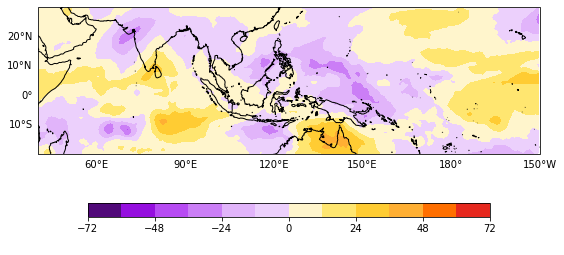

In [3]:
import xarray as xr
import numpy as np
import cmaps
import clim_and_anml as clm 

lats = -20
latn =  30
lon1 =  40
lon2 = 210
time1 = '2017-12-01'
time2 = '2017-12-31'

olr_ds = xr.open_dataset("data/olr.nc")
olrrt = (olr_ds.sel(time=slice(time1,time2),
                    lat=slice(lats,latn),
                    lon=slice(lon1,lon2)).olr)
olrlt = (olr_ds.sel(time=slice('1998-01-01','2016-12-31'),
                    lat=slice(lats,latn),
                    lon=slice(lon1,lon2)).olr) 

olrDayClim = clm.clmDayTLL(olrlt,multiindex=True)
olrDayClim_sm = clm.smthClmDay(olrDayClim,3)
olra = clm.calcDayAnom(olrrt,olrDayClim_sm )
olram = olra.mean(axis=0)

plt.figure(figsize=[9,6])                               
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
ax.set_extent([lon1, lon2, lats, latn], crs=ccrs.PlateCarree())

ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  xlocs=np.arange(-180,240,30), ylocs=np.arange(-20, 40,10), 
                  x_inline=False, y_inline=False, linewidth=0)
gl.right_labels = False
gl.top_labels = False

plot = olram.plot.contourf("lon", "lat", ax=ax,
                           levels=[-72,-60,-48,-36,-24,-12,0,12,24,36,48,60,72],
                           cmap=cmaps.sunshine_diff_12lev,add_colorbar=True,
                           transform=ccrs.PlateCarree(),
                           cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': " "})

plt.show()

因此用Python繪圖有一個很重要的概念，就是繪圖空間`ax`有它自己的座標軸，資料本身也有自己的座標軸，兩者是不一樣的。因此在繪圖的transform引數中，就要告訴繪圖函數資料本身的座標軸為何，這樣才能根據資料和繪圖空間指定的座標軸進行座標轉換。在下一個範例中，我們將500-hPa高度場繪製在極投影地圖上，再說明一次這個觀念。

## 其他地圖投影

在以上的範例中，我們使用了 `ccrs.PlateCarree()`，代表等距長方投影。Cartopy還提供了其他投影的方式，詳見[Cartopy projection list](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)。

**Example 1:** 繪製2017/12月平均500-hPa高度場的極投影 (利用`ccrs.Orthographic`)。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/waynetsai/opt/anac

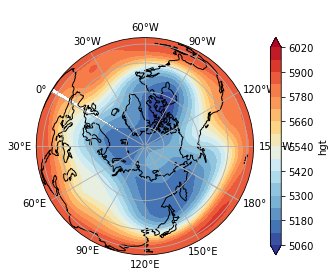

In [4]:
time1 = '2017-12-01'
time2 = '2017-12-31'

zds = xr.open_dataset('data/ncep_r2_h500.2017.nc')
z = zds.sel(time=slice(time1,time2),
            lat=slice(90,0),
            level=500).hgt
zm = z.mean(axis=0)

# Plot settings 
clev = range(5060,6080,60)
proj = ccrs.Orthographic(central_longitude=120, central_latitude=90)
plot = zm.plot.contourf(levels=clev,
                        cmap=cmaps.cmp_b2r, extend='both',
                        subplot_kws=dict(projection=proj),
                        transform=ccrs.PlateCarree())
ax = plot.axes
ax.coastlines()
ax.gridlines(draw_labels=True,
             xlocs=np.arange(-180,240,30))
ax.set_title(' ')

plt.show()

上面的作法必須畫整個半球，如果只想畫特定緯度範圍 (例如：20˚-90˚N)，可以參考下面的作法，是利用`ccrs.NorthPolarStereo()`，但處理邊界的問題較為複雜。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/waynetsai/opt/anac

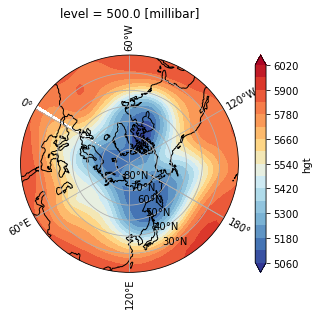

In [5]:
import matplotlib.path as mpath

z = zds.sel(time=slice(time1,time2),
            lat=slice(90,20),
            level=500).hgt
zm = z.mean(axis=0)

# Plot settings 
proj = ccrs.NorthPolarStereo(central_longitude=120)
clev = range(5060,6080,60)
plot = zm.plot.contourf(levels=clev,
                        cmap=cmaps.cmp_b2r, extend='both',
                        subplot_kws=dict(projection=proj),
                        transform=ccrs.PlateCarree())
ax = plot.axes
ax.set_extent([0, 360, 20, 90], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, 
                  xlocs=np.arange(-180,240,60))
gl.ylabels_right = False

plt.show()

再說明一次，在繪製zm的函數中有兩個地方給定了投影方法，一個是subplot_kws (繪圖空間的keyword argument)，一個是transform引數，這是因為在Python的繪圖邏輯中，繪圖空間ax的座標軸和資料本身的座標軸是不一樣的，因此必須要分開給定並且用transform引數做轉換。zm資料是正交方格，解析度是固定的，因此設定資料的座標是`transform=ccrs.PlateCarree()`；而繪圖空間是極投影，所以設定`subplot_kws=dict(projection=proj)`。如此一來，Python就知道如何將資料轉換成適當的座標上。

## 繪製Hovmöller Diagram

設定y軸為時間、x軸為經度 (或x軸為時間、y軸為緯度)，就可以繪製出Hovmöller diagram。若y軸時間演進的順序要改為由上到下，則在繪圖時加入`yincrease=False`。

**Example 2:** 繪製2017年12月5˚S-5˚N平均的逐日Hovmöller diagram。

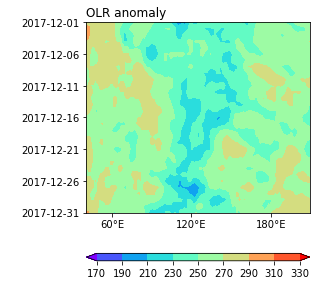

In [6]:
import pandas as pd

lats = -5
latn =  5

olrm = olrrt.mean("lat")
time = pd.to_datetime(olrm.time, format="%Y-%m-%d")

# Plot settings
plt.figure(figsize=(4, 5))     
ax = plt.axes() 
ax.set_xticks(np.arange(60,240,60))
lon_formatter = LONGITUDE_FORMATTER
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(time[0::5])
ax.set_yticklabels(time[0::5].strftime('%Y-%m-%d'))

clevs = range(170,350,20)
plt.title("OLR anomaly", loc='left')
hovm_plot = olrm.plot.contourf(x="lon", y="time",
                               ax=ax, 
                               levels=clevs,                    
                               cmap='rainbow',  
                               yincrease=False,                 # y axis be increasing from top to bottom
                               add_colorbar=True, 
                               extend='both',                   # color bar 兩端向外延伸
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': ' '})
ax.set_xlabel(' ')
ax.set_ylabel(' ')
plt.show()

```{note}
Hovmöller Diagram 不需要用`cartopy` 畫地圖，所以跨越180度不需要特別的設定。
```

## 繪製等值線圖與疊圖

繪製等值線圖使用的方法是`xarray.DataArray.plot.contour()`，和畫等值色圖的方法是一樣的。

**Example 3:** 繪製2021年1月CMORPH降雨和MSLP的月平均，其中降雨以shading表示，MSLP以等值線表示。

Step 1: 準備資料。

In [7]:
lats = -20
latn =  60
lon1 =  30
lon2 = 210

pds = xr.open_dataset('data/gpcp_precip_1979-2019.pentad.nc')
pcp = pds.sel(time=slice('2017-12-01','2017-12-31'), 
              lat=slice(latn,lats),
              lon=slice(lon1,lon2)).data
slp_ds = xr.open_dataset('data/mslp.2017.nc')
mslp = slp_ds.sel(time=slice('2017-12-01','2017-12-31'), 
                  lat=slice(latn,lats),
                  lon=slice(lon1,lon2)).mslp

pcpm = pcp.mean(axis=0)
slpm = mslp.mean(axis=0)
slpm = slpm/100.

Step 2: 繪圖：若要將這兩種場量畫在同一張圖上，意味著兩張圖需要擁有共同的子圖`ax`，因此在繪圖方法函數中的`ax`引數中給定相同的子圖，就可以達到疊圖的目的。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/waynetsai/opt/anac

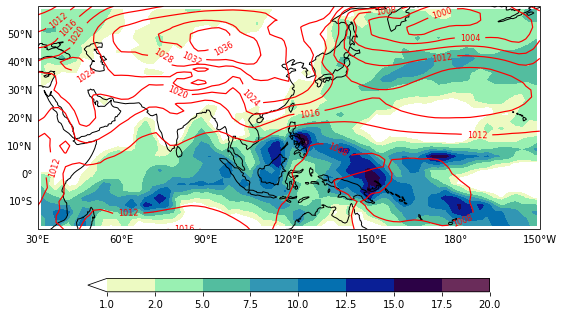

In [8]:
plt.figure(figsize=[9,6])      
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))                         

clev = [1,2,5,7.5,10,12.5,15,17.5,20]
cf = pcpm.plot.contourf("lon", "lat", ax=ax,
                           levels=clev,
                           cmap=cmaps.precip_11lev,
                           add_colorbar=True,
                           transform=ccrs.PlateCarree(),
                           cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': " "})
cl = slpm.plot.contour("lon", "lat", ax=ax,  # 和cf相同的子圖
                         levels=range(980,1048,4),
                         linewidths=1.2,
                         colors='red',
                         transform=ccrs.PlateCarree())

ax.clabel(cl, inline=True, fontsize=8)    # 設定contour line 標籤


ax.set_extent([lon1, lon2, lats, latn], crs=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  xlocs=np.arange(-180,240,30), ylocs=np.arange(-20, 70,10), 
                  x_inline=False, y_inline=False, linewidth=0)
gl.right_labels = False
gl.top_labels = False

plt.show()

## 繪製風場與疊圖

風場屬於多變數資料(U、V)，所以必須將這兩個變數合併成一個Dataset，才能使用`xarray.Dataset.plot.quiver()`的方法函數。而將兩個DataArray合併成一個Dataset，要利用`xarray.merge()`。

**Example 4:** 畫2017年12月OLR和850-hPa水平風場的月平均，其中OLR以等值色圖表示，風場以箭頭向量表示。

In [9]:
lats = -45
latn =  45
lon1 =  30
lon2 = 210

uds = xr.open_dataset('data/ncep_r2_uv850/u850.2017.nc')
vds = xr.open_dataset('data/ncep_r2_uv850/v850.2017.nc')
u = uds.sel(time=slice(time1,time2),
            lat=slice(latn,lats),
            lon=slice(lon1,lon2),
            level=850).uwnd
v = vds.sel(time=slice(time1,time2),
            lat=slice(latn,lats),
            lon=slice(lon1,lon2),
            level=850).vwnd
um = u.mean(axis=0)
vm = v.mean(axis=0)

wnd = xr.merge([um,vm])   # 將兩個DataArray合併成一個Dataset。
wnd 

<xarray.Dataset>
Dimensions:  (lon: 73, lat: 37)
Coordinates:
  * lon      (lon) float32 30.0 32.5 35.0 37.5 40.0 ... 202.5 205.0 207.5 210.0
  * lat      (lat) float32 45.0 42.5 40.0 37.5 35.0 ... -37.5 -40.0 -42.5 -45.0
    level    float32 850.0
Data variables:
    uwnd     (lat, lon) float32 9.181 9.696 9.499 8.617 ... 4.067 4.576 5.064
    vwnd     (lat, lon) float32 2.825 4.076 4.622 4.186 ... 2.835 2.263 1.643

我們先直接把風畫出來看看。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)

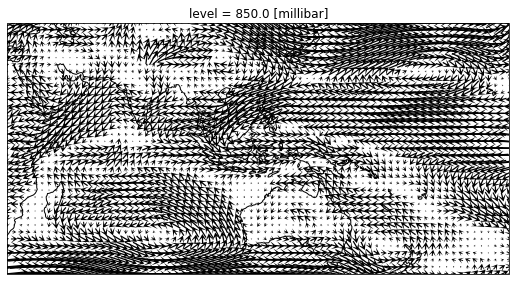

In [10]:
plt.figure(figsize=[9,6])                            
proj = ccrs.PlateCarree(central_longitude=180)    
ax = plt.axes(projection=proj)  
ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()
wind_plt = wnd.plot.quiver(ax=ax,
                           transform=ccrs.PlateCarree(),
                            x='lon', y='lat',
                            u='uwnd', v='vwnd',
                            width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                            scale=200, colors="black",
                            )
plt.show()

以上的圖，箭頭太密，都擠在一起。怎麼調整呢？風場可以每兩格經度和緯度選一次，這樣的話就只會畫在有選資料的網格上。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_line_string)

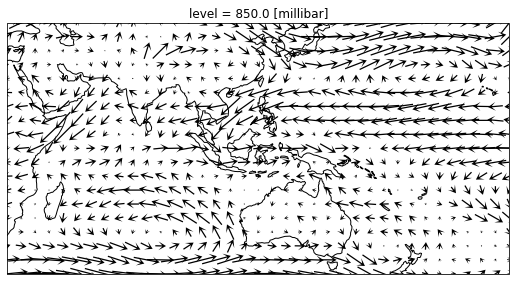

In [11]:
wnd = xr.merge([um[::2,::2],vm[::2,::2]])

plt.figure(figsize=[9,6])                            
proj = ccrs.PlateCarree(central_longitude=180)    
ax = plt.axes(projection=proj)  
ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()

wind_plt = wnd.plot.quiver(ax=ax,
                           transform=ccrs.PlateCarree(),
                            x='lon', y='lat',
                            u='uwnd', v='vwnd',
                            width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                            scale=200, colors="black",
                            )
plt.show()

如果跟OLR疊在一起看：

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/waynetsai/opt/anac

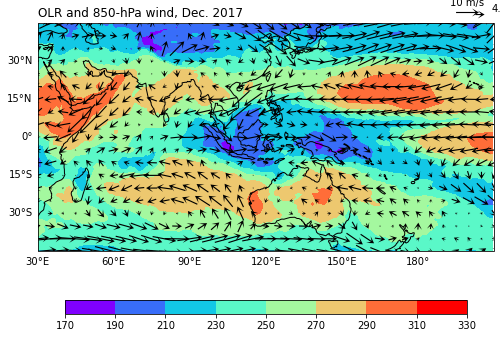

In [12]:
olr = olr_ds.sel(time=slice(time1,time2),
                 lat=slice(lats,latn),
                 lon=slice(lon1,lon2)).olr
olrm = olr.mean(axis=0)

plt.figure(figsize=[9,6])                            
proj = ccrs.PlateCarree(central_longitude=180)    
ax = plt.axes(projection=proj)  
ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()

olr_plot = olrm.plot.contourf("lon", "lat", ax=ax,
                               levels=range(170,350,20),
                               cmap='rainbow', add_colorbar=True,
                               transform=ccrs.PlateCarree(),
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': " "})

wind_plt = wnd.plot.quiver(ax=ax,
                           transform=ccrs.PlateCarree(),
                            x='lon', y='lat',
                            u='uwnd', v='vwnd',
                            width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                            scale=200, colors="black",
                            )

# 加上風標
qk = 10
qv_key = ax.quiverkey(wind_plt,0.94,1.05,10,r'10 m/s',labelpos='N', labelsep =0.05, color='black')

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  xlocs=np.arange(30,240,30), ylocs=np.arange(-45, 60, 15), 
                  x_inline=False, y_inline=False, linewidth=0)
gl.right_labels = False
gl.top_labels = False
ax.set_title(' ')
ax.set_title('OLR and 850-hPa wind, Dec. 2017', loc='left')

plt.show()


注意上圖`olrm.plot.contourf()`和`wnd.plot.quiver()`的`ax`引數都是`ax=ax`，表示這兩個圖共用一個子圖，所以可以將風場疊在OLR上。

加上風標可以使用`ax.quiverkey()`函數，用法是

> (method) quiverkey: (Q: Quiver, X: float, Y: float, U: float, label: str, **kw: Any) -> QuiverKey

也就是在`Q`指定要畫哪一張圖的風標，然後給定繪製風標的位置，以及風標的參考數值。

## 繪製流線場

方法基本上跟畫風場一模一樣，只是將`plot.quiver()`改為`plot.streamplot()`。

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/waynetsai/opt/anac

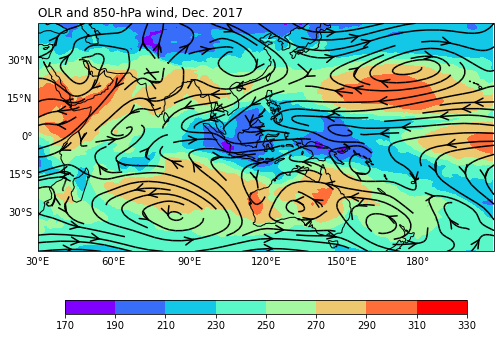

In [13]:
wnd = xr.merge([um,vm]) 

plt.figure(figsize=[9,6])                            
proj = ccrs.PlateCarree(central_longitude=180)    
ax = plt.axes(projection=proj)  
ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()

olr_plot = olrm.plot.contourf("lon", "lat", ax=ax,
                               levels=range(170,350,20),
                               cmap='rainbow', add_colorbar=True,
                               transform=ccrs.PlateCarree(),
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': " "})

wind_plt = wnd.plot.streamplot(ax=ax,
                              transform=ccrs.PlateCarree(),
                               x='lon', y='lat',
                               u='uwnd', v='vwnd',
                               arrowsize=2,arrowstyle='->',
                               color="black",
                               )

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                  xlocs=np.arange(30,240,30), ylocs=np.arange(-45, 60, 15), 
                  x_inline=False, y_inline=False, linewidth=0)
gl.right_labels = False
gl.top_labels = False
ax.set_title(' ')
ax.set_title('OLR and 850-hPa wind, Dec. 2017', loc='left')

plt.show()


## 多格子圖 (Panel Plots/Facet Grid)

**Example 5:** 繪製2017年12月的候 (pentad) 平均OLR和850-hPa風場，畫成2欄 (columns) 3列 (rows) 共6個子圖，其中排列順序由上到下、再從左到右。

### 使用`xarray`的`plot.FacetGrid`函數

在以上的單元已經學過如何利用xarray畫2維的地圖，但如果資料是3維，也就是多包含了時間軸，利用xarray畫圖函數的Faceting方法可以直接一次畫多格的圖。以等值圖為例，`xarray.plot.contourf()`的`**kwargs`中有

- row (string, optional) – If passed, make row faceted plots on this dimension name.

- col (string, optional) – If passed, make column faceted plots on this dimension name.

如果加入了這兩個引數，就會以Faceting的方式呈現。現在我們來試試看，首先先將OLR計算成候平均：

In [14]:
time = pd.to_datetime(olr.time, format="%Y%m%d")
olr_pm = olr.coarsen(time=5,boundary='trim',coord_func='min').mean()
olr_pm

<xarray.DataArray 'olr' (time: 6, lat: 90, lon: 180)>
array([[[224.86111, 226.3981 , 224.41855, ..., 229.07529, 228.11858,
         225.66814],
        [227.775  , 230.82764, 233.42639, ..., 229.67593, 228.94986,
         231.03325],
        [232.12924, 235.39009, 236.77686, ..., 232.45215, 233.25284,
         232.22256],
        ...,
        [201.59805, 197.42513, 195.47064, ..., 205.43083, 199.38724,
         194.48688],
        [204.20157, 198.4709 , 187.70116, ..., 208.23874, 201.46062,
         191.78712],
        [203.57655, 198.38205, 191.63045, ..., 211.93823, 205.63066,
         195.4493 ]],

       [[230.83244, 233.1549 , 229.3143 , ..., 243.84912, 243.8317 ,
         243.89192],
        [234.94585, 234.7456 , 233.281  , ..., 245.73581, 245.56096,
         246.63486],
        [241.1687 , 240.02641, 239.55704, ..., 245.10173, 245.74585,
         244.60786],
...
        [212.4322 , 210.6854 , 208.42285, ..., 220.7081 , 222.06192,
         222.85306],
        [218.50546, 212.52534, 212.26411, ..., 217.88777, 217.91216,
         218.97366],
        [221.8818 , 218.17514, 218.70053, ..., 215.66788, 215.16782,
         209.17368]],

       [[230.7843 , 230.65596, 231.08252, ..., 240.9209 , 241.09586,
         240.14005],
        [235.40532, 233.5983 , 235.3424 , ..., 236.53694, 234.71167,
         234.35791],
        [241.88773, 240.05363, 238.7875 , ..., 232.11848, 230.01367,
         230.08188],
        ...,
        [220.19931, 221.91418, 226.62581, ..., 222.19429, 226.35947,
         226.99039],
        [225.14436, 224.89417, 225.91891, ..., 212.57788, 215.19876,
         223.09372],
        [224.86201, 224.81381, 223.41829, ..., 202.36899, 208.63791,
         213.91812]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-12-01 2017-12-06 ... 2017-12-26
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 206.5 207.5 208.5 209.5
  * lat      (lat) float32 -44.5 -43.5 -42.5 -41.5 -40.5 ... 41.5 42.5 43.5 44.5
Attributes:
    standard_name:  toa_outgoing_longwave_flux
    long_name:      NOAA Climate Data Record of Daily Mean Upward Longwave Fl...
    units:          W m-2
    cell_methods:   time: mean area: mean

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


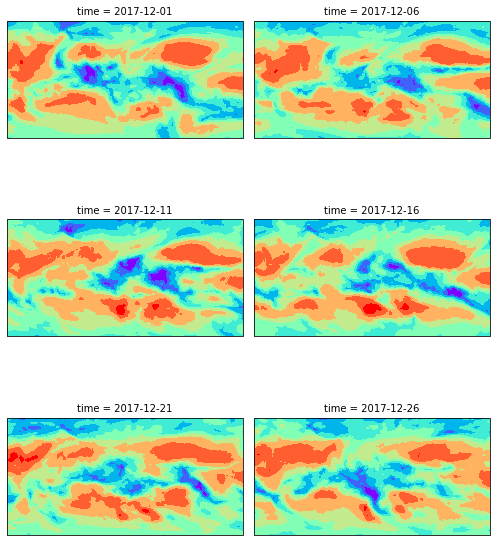

In [15]:
olr_plot = olr_pm.plot.contourf('lon','lat',
                                col='time', 
                                col_wrap=2,
                                levels=range(170,350,20),
                                cmap='rainbow', add_colorbar=False,
                                transform=ccrs.PlateCarree(),
                                subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)})

### 展開並操控子圖`axes`

以上的圖有一些問題。
1. Color bar: FacetGrid有方法函數`add_colorbar()`。
2. 缺乏地形、座標軸，此時就需要用`flatten`展開`axes`使子圖成為一個陣列，這樣我們才有辦法去操控每一張子圖來調整細節。由於每張子圖要調整的內容是相同的，所以可以寫一個迴圈 (loop) 來控制。
3. 風場的FacetGrid Object沒有辦法直接疊在另一個FacetGrid Object上，因此要在子圖中畫風場，也需要透過展開的`axes`來處理。
4. 圖都擠在一起，尤其第二欄的y軸和第一欄的圖重疊。這可以透過`plt.subplots_adjust()`來修改子圖之間的間距，用法如下：  
   > matplotlib.pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)  
   
   ![](images/fig9.1.png)
5. 我們期望順序是由上到下、由左至右；因此要調整一下 **時間排列的順序**：

~~~
xarray畫圖順序：                      期望的順序：   
|   0   |   1   |                   |  0  |  3  |  
|   2   |   3   |                   |  1  |  4  |  
|   4   |   5   |                   |  2  |  5  |  
~~~

所以配合xarray畫圖順序，我們將DataArray的時間軸重新排列一下：


In [16]:
## 設定繪圖順序矩陣。
porder = [0,3,1,4,2,5] 

代入`olr`和`wnd`的矩陣中：

/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/waynetsai/opt/anaconda3/envs/p3/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/var/folders/5f/jxsyfmmj2

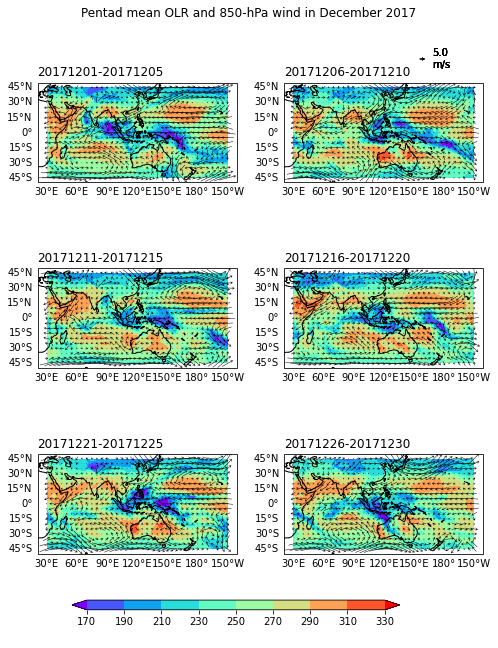

In [17]:
upm = u.coarsen(time=5,boundary='trim',coord_func='min').mean()
vpm = v.coarsen(time=5,boundary='trim',coord_func='min').mean()
wnd = xr.merge([upm[porder,::2,::2],vpm[porder,::2,::2]])

olr_plot = (olr_pm[porder,:,:]
                  .plot.contourf('lon','lat',
                                 col='time', 
                                 col_wrap=2,
                                 levels=range(170,350,20),
                                 cmap='rainbow', add_colorbar=False,
                                 extend='both',
                                 transform=ccrs.PlateCarree(),
                                 subplot_kws={"projection": ccrs.PlateCarree(central_longitude=180)}))

### Matplotlib function
fig = olr_plot.fig
axes = olr_plot.axes

i = 0
for ax in axes.flat:  ## 展開並操控子圖。
    wnd_plot = wnd.isel(time=i).plot.quiver(
                                ax=ax,
                                transform=ccrs.PlateCarree(),
                                 x='lon', y='lat',
                                 u='uwnd', v='vwnd',
                                 width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                                 scale=200, colors="black"
                                 )
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                      xlocs=np.arange(-180,240,30), ylocs=np.arange(-45, 60,15), 
                      x_inline=False, y_inline=False, linewidth=0)
    gl.right_labels = False
    gl.top_labels = False
    ax.set_title(' ')
    ax.set_title(time[i*5].strftime('%Y%m%d') + '-' + time[i*5+4].strftime('%Y%m%d'), loc='left')
    
    i = i + 1

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.15, 0.05, 0.65, 0.015])
# Draw the colorbar 將colorbar畫在cbar_ax這個軸上。
cbar = olr_plot.add_colorbar(cax=cbar_ax,
                             orientation='horizontal',
                             ticks=range(170,350,20),
                             label=' ')  

# 調整圖的排版細節
#fig.subplots_adjust(bottom=0.05, wspace=0.2, hspace=0.01)
plt.tight_layout()

# 加上圖的標題
plt.suptitle('Pentad mean OLR and 850-hPa wind in December 2017')


plt.show()


## Homework 2

```{admonition} Homework #2
:class: seealso
(三選一)
1. 請根據手上正在進行的研究，繪製分析結果圖一張。
2. 根據最近閱讀的文獻，重製分析結果圖一張。
3. 複習本次工作坊的內容，重現分析結果圖一張。

請盡可能用xarray開啟檔案、分析資料和繪圖。 

請將程式碼以及結果的繪圖一同繳交至Google Classroom，其中圖需包含圖需包簡要圖說，介紹圖的內容。 
繳交位置：[Google Classroom](https://classroom.google.com/c/NDUwNDY0OTY5NDc5?cjc=hv5ndug) 
```